# Create a Multi-source datamodule for MNIST
- Jan 6, 2021

Each "style" of monochrome-mnist dataset puts a different color for the digit pixels.
This notebooks shows 

- how we can create each of the datasets so that it outputs a consistent data sample
at each call for the `__getitem__` method (eg. via indexing `myDataset[item_idx]`)

- how to create a single dataset that outputs a datapoint from multiple datasets
in a balanced way, ie. sampling as uniformly as possible to sample from any one of the 
datasets: 

Let's say we have 3 datasets, ds0, ds1, ds2, each of which contains n0, n1, n2 datapoints/observations
respectively. Currently the implementation of `ConcatDataset` in `pytorch` samples a datapoint x from 
a single datasets d = [ds0, ds1, ds2] under a uniform distribution: p(x) = 1/(n0+n1+n2). Consequently, 
this "uniform" distribution puts a uniform probability mass on each datasample in the concatenated dataset, 
but the probability distribution of a sample coming from each dataset, say $\pi = [\pi_0, \pi_1, \pi_2]$ is not uniform, but rather a ratio of the number of samples, ie. $[n_0/n, n_1/n, n_2/n]$ where $n = n_0+n_1+n_2$.  
If we want $\pi$ to be a uniform distribution of selected source dataset, we 
could first compute the ratio of the dataset sizes, and input weighted number of datasets when creating 
the final, single dataset (of multiple sources).

We will demonstrate how to use the ratio of dataset sizes to create a single, multi-source dataset from multiple datasources, so that the final, multi-course dataset outputs a datapoint, uniformly from any consitutent data source.





## Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [3]:
import pandas as pd

import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any, List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar

from pprint import pprint
from ipdb import set_trace as brpt

In [4]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset,random_split

from torchvision import datasets, transforms

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers


# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [5]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
# print(sys.path)

Project root:  /data/hayley-old/Tenanbaum2000
Src folder:  /data/hayley-old/Tenanbaum2000/src
This nb path:  /data/hayley-old/Tenanbaum2000/nbs

/data/hayley-old/Tenanbaum2000 added to the path.


In [6]:
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule

from src.visualize.utils import show_timg, show_timgs, show_batch, make_grid_from_tensors
from src.utils.misc import info
from collections import OrderedDict, defaultdict


## Create MonoMNIST datasets with proper `transforms`

A MonoMNIST dataset outputs a tuple of 

In [7]:
from src.data.datasets.mono_mnist import MonoMNIST

In [8]:
mono_dir = ROOT/'data/Mono-MNIST'
GrayMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                      color='gray',
                      train=True)

RedMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='red',
                    train=True)
GreenMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='green',
                      train=True)
BlueMNIST = MonoMNIST(data_root=ROOT/'data/Mono-MNIST',
                    color='blue',
                     train=True)

In [9]:
for ds in [GrayMNIST, RedMNIST, GreenMNIST, BlueMNIST]:
    print(f"{ds.name}: {len(ds)}")
    for i in range(3):
        x,y = ds[i]
        if i == 0:
            info(x, "===x===")
            print(y)
#         show_timg(x)
#         plt.title(y)
#         plt.show()

train_mnist_gray_seed-123: 15015


ValueError: too many values to unpack (expected 2)

In [10]:
ds = RedMNIST
dl = DataLoader(ds)

In [11]:
x, y = next(iter(dl))
x.shape, y.shape

ValueError: too many values to unpack (expected 2)

---

## Test MonoDatamodule for each color

In [ ]:
from src.data.datamodules import MonoMNISTDataModule
in_shape = (3,32,32)
batch_size=16
color = 'red'

dm = MonoMNISTDataModule(
    data_root=mono_dir,
    color=color,
    seed=123,
    in_shape=in_shape,
    batch_size=batch_size
)
dm.setup('fit')

In [ ]:
for color in ['gray', 'red', 'green', 'blue']:
    dm = MonoMNISTDataModule(
        data_root=Path('/data/hayley-old/Tenanbaum2000/data/Mono-MNIST/'),
        color=color,
        seed=123,
        in_shape=in_shape,
        batch_size=batch_size
    )
    dm.setup('fit')
    show_batch(dm, cmap='gray' if color=='gray' else None) 
    plt.show()

---

## Create a Multi-source monochrome dataset 
by concatenating multipel MonoMNIST datasets

In [ ]:
dsets = [GrayMNIST, RedMNIST, GreenMNIST, BlueMNIST]
print("===Num. of observations===")
print([len(ds) for ds in dsets])

In [ ]:
ds = ConcatDataset(dsets)
ordered_dl = DataLoader(ds, batch_size=32, shuffle=False)
shuffled_dl = DataLoader(ds, batch_size=32, shuffle=True)

In [ ]:
for dl in [ordered_dl, shuffled_dl]:
    x,y = next(iter(dl))
    show_timgs(x)
    print(y)
    print("===")

Note:

- In the batch from the `ordered_dl`, we see all images of digit_id 5 because that is how each Monochrome dataset is created (ie. appending all images of 5, then another digit_id, etc).
- The ordered_dl iterates over all images in the first dataset (ie. GrayMNIST) and then iterate over the next datasets in order (because the DataLoader is created with `shuffle=False`)

Similarly, we can create a multi-source dataset with two-styles as below.

In [ ]:
dsets = [RedMNIST, GreenMNIST] #[GrayMNIST, RedMNIST, GreenMNIST, BlueMNIST]
print("===Num. of observations===")
print([len(ds) for ds in dsets])

# Create a multi-source dataset
ds = ConcatDataset(dsets)

# DataLoader
dl = DataLoader(ds, batch_size=32, shuffle=True)

# Show a batch
x,y = next(iter(dl))
show_timgs(x)
print(y)
print("===")

Pretty neat!:)

---

## Create a Multisource MonoMNIST DataModule
Next, we work on creating a pytorch-lightning's DataModule class that encompasses this multi-source dataset.

In [12]:
from src.data.datamodules import MultiMonoMNISTDataModule

In [ ]:
collection = {"red": RedMNIST,
              "green": GreenMNIST,
              "blue": BlueMNIST,
              "gray": GrayMNIST}

def get_mono_dsets(colors: List[str], collection:Dict[str, MonoMNIST]):
    dsets = []
    for color in colors:
        dsets.append(collection[color])
    return dsets

In [24]:
colors = ['red', 'green']
seed = 123
in_shape = (3, 32,32)
batch_size=32

# Create a multi-source dataset
dm = MultiMonoMNISTDataModule(
    data_root=mono_dir,
    colors=colors,
    seed=seed,
    in_shape=in_shape,
    batch_size=batch_size,
    shuffle=True,
)
dm.setup('fit')

> /data/hayley-old/Tenanbaum2000/src/data/datasets/multisource_mono_mnist.py(120)get_mono_dsets()
    119             breakpoint()
--> 120             dsets.append(ds)
    121         return dsets



ipdb>  ds


ipdb>  ds.colorstr_transform


Lambda()


ipdb>  ds[0]['color']


0


ipdb>  c


> /data/hayley-old/Tenanbaum2000/src/data/datasets/multisource_mono_mnist.py(119)get_mono_dsets()
    118                           train=self.train)
--> 119             breakpoint()
    120             dsets.append(ds)



ipdb>  ds


ipdb>  ds.color


'green'


ipdb>  ds[0]['color']


1


ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([1, 1, 7, 2, 9, 2, 6, 6, 2, 8, 6, 9, 3, 7, 0, 7, 3, 8, 1, 0, 7, 3, 0, 3,
        1, 9, 8, 8, 8, 5, 0, 4])
tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1])
===


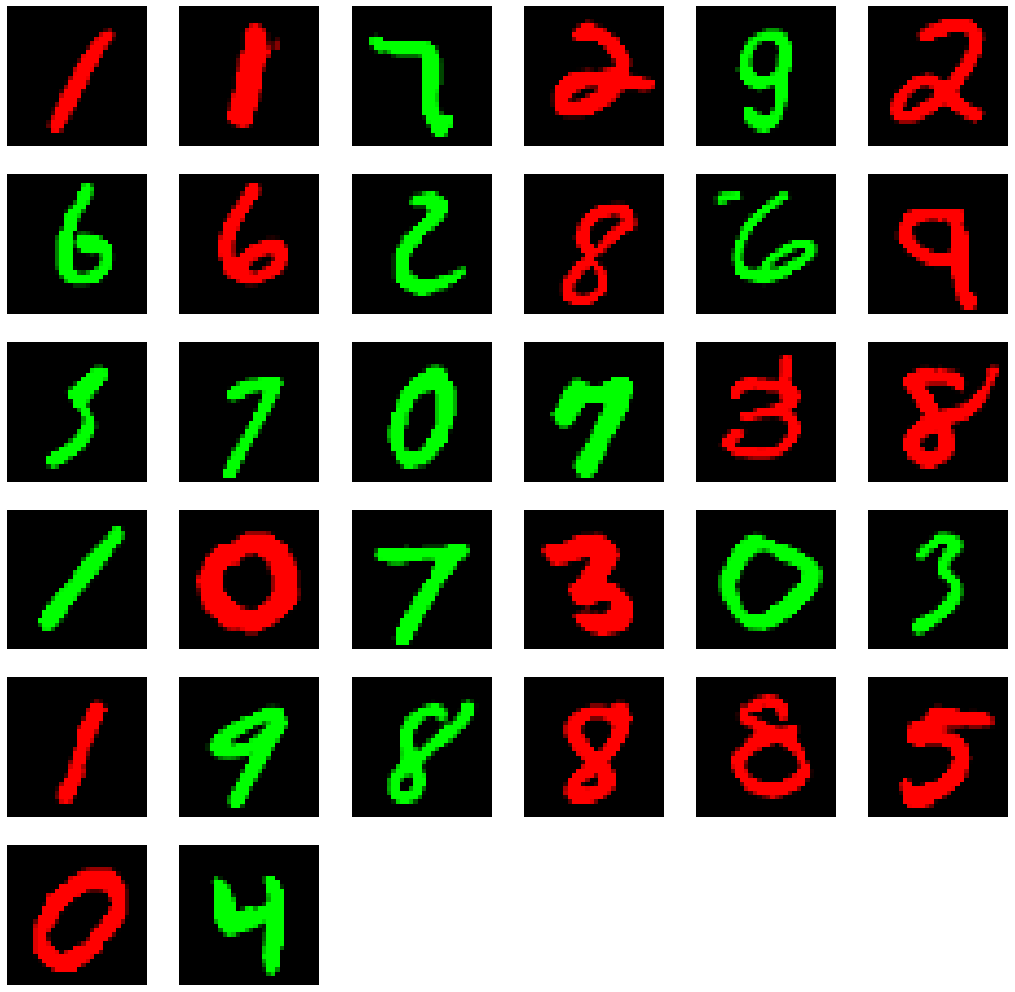

In [26]:

dl = dm.train_dataloader()
# Show a batch
batch = next(iter(dl))
x = batch['img']
label_c = batch['digit']
label_s = batch['color']
show_timgs(x)
print(label_c)
print(label_s)
print("===")

Ta-Da!

---
## Improvement 1: Multisource Mono-MNIST Dataset
Create a new dataset class that holes multiple MonoMNIST dataset

In [ ]:
from src.data.datasets import MultiMonoMNIST
import numpy as np

In [ ]:
ds = MultiMonoMNIST(
    data_root=mono_dir,
    colors=colors,
    seed=seed
)

In [ ]:
ds.name

In [ ]:
ds.get_mono_dsets(ds.colors)

In [ ]:
ds0, ds1 = ds.dsets
x,y = ds0[1]
info(x)
print(y)
show_timg(x)

In [ ]:
for i in range(10):
    idx = np.random.randint(len(ds))
    x,y = ds[idx]
    info(x)
    show_timg(x)
    plt.title(y)

## Improvement 2: Use the multisource MonoMNIST dataset as input to the datamodule


In [ ]:
dm = MultiMonoMNISTDataModule(
    full_ds=ds,
    colors=ds.colors,
    seed=ds.seed,
    in_shape=in_shape,
    batch_size=batch_size,
    shuffle=True,
)
dm.setup('fit')

In [ ]:
dl = dm.train_dataloader()
# Show a batch
x,y = next(iter(dl))
show_timgs(x)
print(y)
print("===")

---


## Final Workflow
- Specify dataset settings 
  - colors, batch_size, shape of each datapoint (`in_shape`)
- Initialize a multisource MonoMNIST dataset
- Initialize a multisource MonoMNIST datamodule using the dataset

In [ ]:
from src.data.datasets import MultiMonoMNIST
from src.data.datamodules import MultiMonoMNISTDataModule

In [28]:
# Dataset settings
data_dir = Path("/data/hayley-old/Tenanbaum2000/data/Mono-MNIST/")
colors = ['red', 'green']
seed = 123
in_shape = (3, 32,32)
batch_size = 32


# # Create a concat dataset from multiple mono-mnist datasets
# ds = MultiMonoMNIST(
#     data_root=data_dir,
#     colors=colors,
#     seed=seed
# )
# print("===Num. of observations===")
# print([len(d) for d in ds.dsets])

# Create a multisource mono-mnist datamodule
dm = MultiMonoMNISTDataModule(
    data_root=data_dir,
    colors=colors,
    seed=seed,
    in_shape=in_shape,
    batch_size=batch_size,
    shuffle=True,
)
dm.setup('fit')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

tensor([8, 1, 2, 1, 5, 7, 7, 2, 6, 7, 0, 3, 1, 7, 9, 0, 3, 8, 0, 5, 9, 6, 7, 6,
        8, 9, 4, 0, 7, 9, 8, 5])
tensor([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1])
===


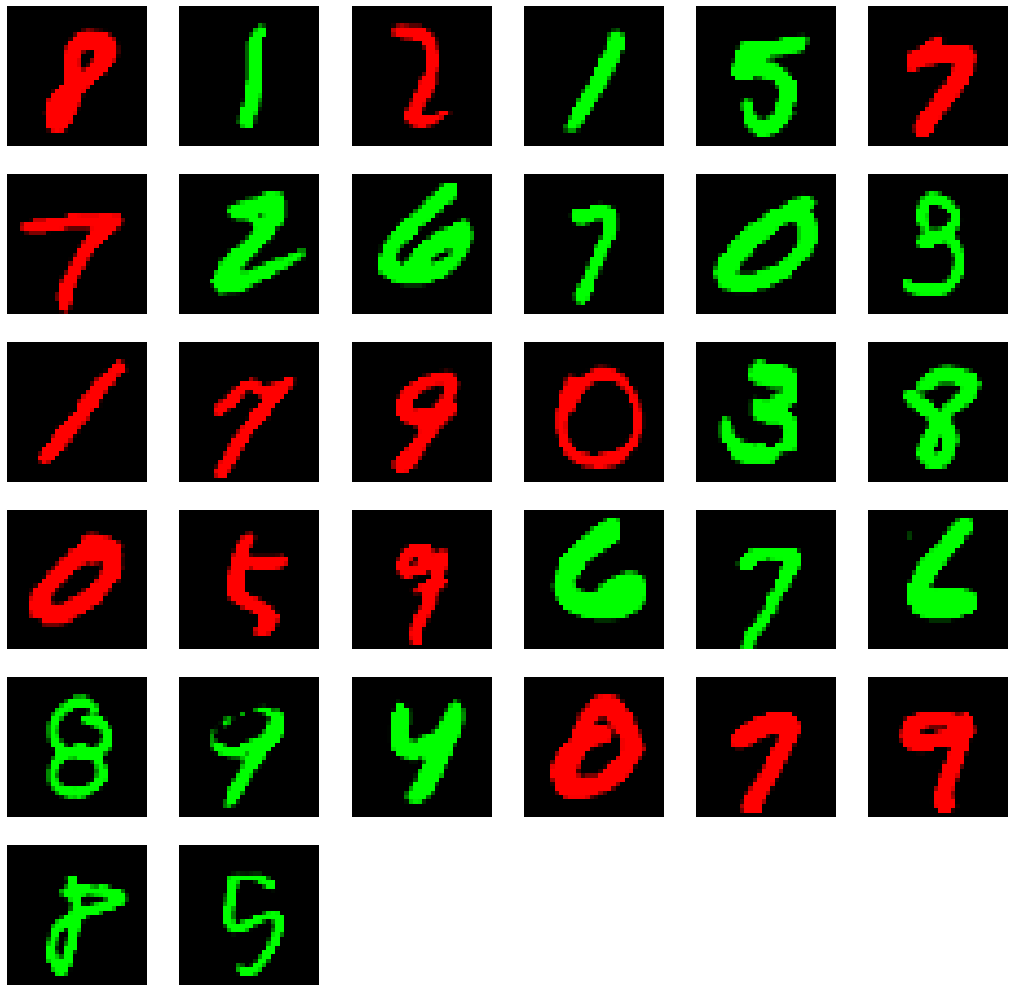

In [29]:
dm.name
dl = dm.train_dataloader()
# Show a batch
batch = next(iter(dl))
x = batch['img']
label_c = batch['digit']
label_s = batch['color']
show_timgs(x)
print(label_c)
print(label_s)
print("===")